In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
data = pd.read_pickle('data/data.pkl')

In [4]:
data.shape

(923910, 286)

In [5]:
agg_functions = dict.fromkeys(data, 'mean')
agg_functions.update(dict.fromkeys(data.columns[data.dtypes.eq(object)], 'first'))
agg_functions.update(dict.fromkeys(data.columns[data.dtypes.eq('<M8[ns]')], 'first'))
agg_functions.update({'rt': 'median'})
agg_functions.update(dict.fromkeys(["DQ_0%d"%i for i in range(2,9)], 'first'))
del agg_functions['PID_fixed']
del agg_functions['session']
del agg_functions['experiment']

In [6]:
pp_data = data[data.analysis].groupby(['PID_fixed']).agg(agg_functions).reset_index()
pp_data = pp_data.drop(columns = 'sensor_type') # Not sure why this is necessary, but R does not seem to like this variable

In [7]:
session_data = data[data.analysis].groupby(['PID_fixed','experiment']).agg(agg_functions)

In [8]:
pp_data.shape, session_data.shape

((1118, 283), (4449, 283))

In [9]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

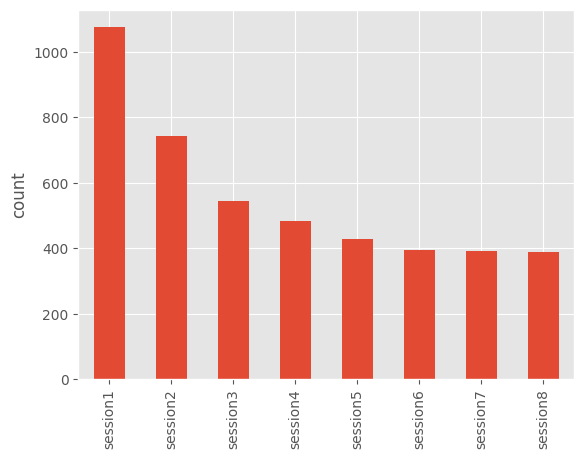

In [10]:
session_data.reset_index().experiment.value_counts().plot(kind='bar')
plt.ylabel('count')
plt.show()

In [11]:
pp_data.DG_03 = pp_data.DG_03.astype(int)

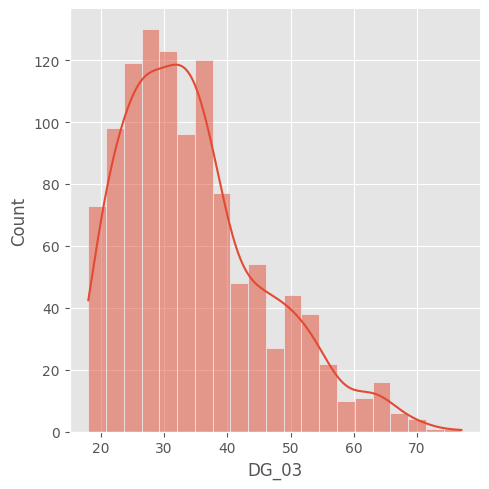

In [12]:
sns.displot(data=pp_data,
           x='DG_03',
           kde=True)
plt.show()

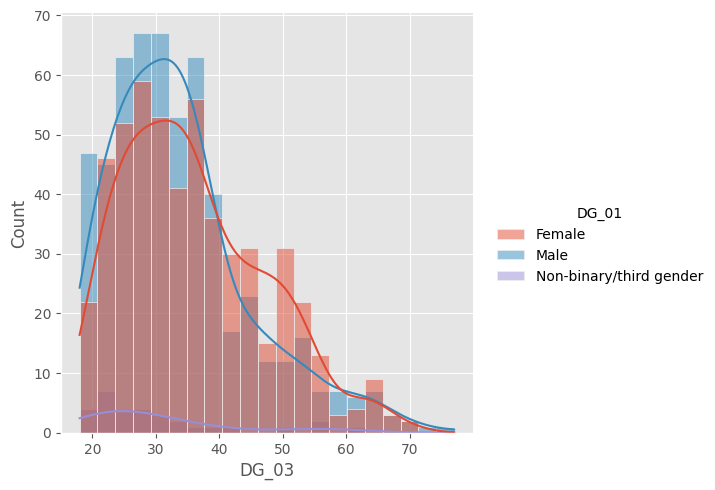

In [13]:
sns.displot(data=pp_data,
           x='DG_03',
           hue='DG_01',
           multiple='layer', 
           kde=True)
plt.show()

In [14]:
np.mean(pp_data.DG_03),  np.std(pp_data.DG_03)

(34.73881932021467, 11.234838132903503)

In [15]:
pp_data['age'] = pp_data.DG_03.transform(float)

## Counterbalancing
a technique used to deal with order effects when using a repeated measures design. With counterbalancing, the participant sample is divided in half, with one half completing the two conditions in one order and the other half completing the conditions in the reverse order.

<AxesSubplot:>

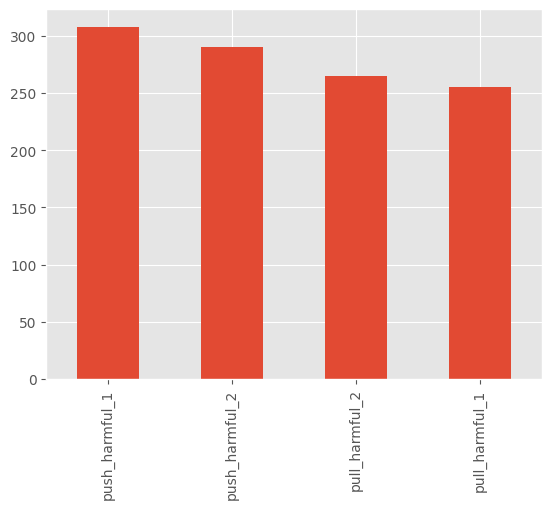

In [16]:
pp_data.condition.value_counts().plot.bar()

## RT

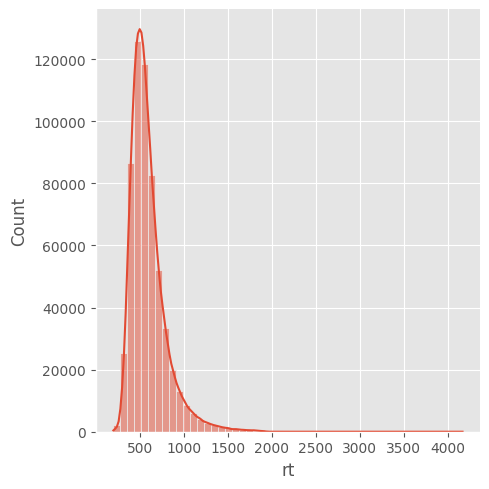

In [17]:
sns.displot(data[data.analysis].rt, 
            kde=True,
           kind='hist',
           bins=50)
plt.show()

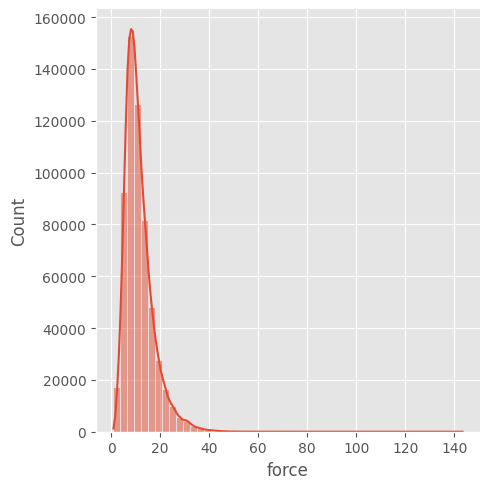

In [18]:
sns.displot(data[data.analysis].force, 
            kde=True,
           kind='hist',
           bins=50)
plt.show()

### Log Transformed

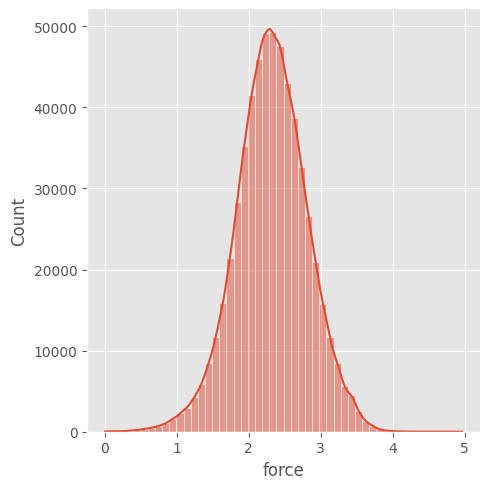

In [19]:
sns.displot(np.log(data[data.analysis].force), 
            kde=True,
           kind='hist',
           bins=50)
plt.show()

In [20]:
def get_df(dataframe):
    dataframe[["C5_0%d"%i for i in range(2,8)]] = dataframe.groupby('participant')[["C5_0%d"%i for i in range(2,8)]].transform('first').replace({'never':1,'almost never':2,'sometimes':3,'fairly often':4,'very often':5})
    # Post-error trials for exploration
    dataframe['post_error'] = dataframe.error.shift(1)
    dataframe.loc[0,'post_error'] = False
    # Task trial for exploration
    dataframe['task_trial'] = dataframe.block_trial# * ((data.block>3).astype(int)+1)
    dataframe.loc[(dataframe.block.isin([3,6])),'task_trial'] = data.loc[(data.block.isin([3,6])),'task_trial']+20
    # Session order and time of the day for exploration
    dataframe['time'] = pd.to_datetime(dataframe.drawn_at_unix, unit='ms')
    dataframe['session_start_time'] = dataframe.groupby(['participant','session']).time.transform('first')
    dataframe['session_order'] = dataframe.groupby('participant').session_start_time.transform(lambda x: x.rank(method='dense'))
    date_time = pd.to_datetime(dataframe.drawn_at_unix, unit='ms')
    dataframe['time_of_day'] = date_time.dt.hour + date_time.dt.minute/60
    dataframe['gender'] = dataframe.DG_01
    dataframe['is_female'] = dataframe.gender.str.contains("Female")
    dataframe['session_number'] = dataframe.experiment.str[-1:].astype(int)
    # Reducing size of the dataframe used in R-analyses
    df = dataframe[dataframe.analysis][["participant","PID_fixed","experiment","session","stimulus_set","stimulus","is_pull","rt","rt_inv","force","response","dq_mean","post_error","trial","task_trial","block_trial","time_of_day","age","gender","session_number","is_female","condition", "device"] + ["DQ_0%d"%i for i in range(2,9)] + ["C5_0%d"%i for i in range(2,8)]]
    df['session_number'] = df.session_number-1 # Setting first session to 0
    df['is_happy'] = df.stimulus_set.str.contains("happy")
    df['is_dirty'] = df.stimulus_set.str.contains("dirty")
    return df

In [21]:
df = get_df(data)

In [22]:
df['session_number_c'] = df.session_number - df.session_number.mean()
df['is_happy_c'] = df.is_happy - df.is_happy.mean()
df['is_pull_c'] = df.is_pull - df.is_pull.mean()

In [23]:
happy_data = df[df.session.str.contains('sad')]
dirty_data = df[df.session.str.contains('harmful')]

In [24]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [25]:
formula = "rt ~ (is_pull * is_happy * session_number_c)"
fixed_rt_happy = smf.mixedlm(formula,
                            happy_data,
                            re_formula="is_pull * is_happy",
                            groups="session_number_c").fit()

/home2/anmol.goel/miniconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home2/anmol.goel/miniconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home2/anmol.goel/miniconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [26]:
# %load_ext rpy2.ipython

In [27]:
fixed_rt_happy.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Mixed Linear Model Regression Results
======================================================================================================
Model:                           MixedLM               Dependent Variable:               rt           
No. Observations:                321320                Method:                           REML         
No. Groups:                      8                     Scale:                            34681.3900   
Min. group size:                 28755                 Log-Likelihood:                   -2135475.2982
Max. group size:                 76100                 Converged:                        Yes          
Mean group size:                 40165.0                                                              
------------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------------------------------------
Intercept                                               530.797    2.049 259.003 0.000 526.781 534.814
is_pull[T.True]                                          23.678    1.207  19.615 0.000  21.312  26.044
is_happy[T.True]                                         51.316    1.080  47.500 0.000  49.198  53.433
is_pull[T.True]:is_happy[T.True]                        -80.601    1.917 -42.040 0.000 -84.359 -76.843
session_number_c                                          0.920    0.855   1.076 0.282  -0.756   2.596
is_pull[T.True]:session_number_c                         -2.709    0.513  -5.281 0.000  -3.714  -1.703
is_happy[T.True]:session_number_c                        -1.938    0.458  -4.230 0.000  -2.836  -1.040
is_pull[T.True]:is_happy[T.True]:session_number_c         4.627    0.812   5.695 0.000   3.034   6.219
session_number_c Var                                     27.355    0.138                              
session_number_c x is_pull[T.True] Cov                   -4.074    0.017                              
is_pull[T.True] Var                                       4.248    0.029                              
session_number_c x is_happy[T.True] Cov                  -2.200                                       
is_pull[T.True] x is_happy[T.True] Cov                    2.224    0.020                              
is_happy[T.True] Var                                      2.232                                       
session_number_c x is_pull[T.True]:is_happy[T.True] Cov   3.067    0.056                              
is_pull[T.True] x is_pull[T.True]:is_happy[T.True] Cov   -7.058    0.036                              
is_happy[T.True] x is_pull[T.True]:is_happy[T.True] Cov  -2.800    0.038                              
is_pull[T.True]:is_happy[T.True] Var                     13.890    0.063                              
======================================================================================================

"""

In [89]:
fixed_rt_happy.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Mixed Linear Model Regression Results
======================================================================================================
Model:                           MixedLM               Dependent Variable:               rt           
No. Observations:                321320                Method:                           REML         
No. Groups:                      8                     Scale:                            34681.3900   
Min. group size:                 28755                 Log-Likelihood:                   -2135475.2982
Max. group size:                 76100                 Converged:                        Yes          
Mean group size:                 40165.0                                                              
------------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
------------------------------------------------------------------------------------------------------
Intercept                                               530.797    2.049 259.003 0.000 526.781 534.814
is_pull[T.True]                                          23.678    1.207  19.615 0.000  21.312  26.044
is_happy[T.True]                                         51.316    1.080  47.500 0.000  49.198  53.433
is_pull[T.True]:is_happy[T.True]                        -80.601    1.917 -42.040 0.000 -84.359 -76.843
session_number_c                                          0.920    0.855   1.076 0.282  -0.756   2.596
is_pull[T.True]:session_number_c                         -2.709    0.513  -5.281 0.000  -3.714  -1.703
is_happy[T.True]:session_number_c                        -1.938    0.458  -4.230 0.000  -2.836  -1.040
is_pull[T.True]:is_happy[T.True]:session_number_c         4.627    0.812   5.695 0.000   3.034   6.219
session_number_c Var                                     27.355    0.138                              
session_number_c x is_pull[T.True] Cov                   -4.074    0.017                              
is_pull[T.True] Var                                       4.248    0.029                              
session_number_c x is_happy[T.True] Cov                  -2.200                                       
is_pull[T.True] x is_happy[T.True] Cov                    2.224    0.020                              
is_happy[T.True] Var                                      2.232                                       
session_number_c x is_pull[T.True]:is_happy[T.True] Cov   3.067    0.056                              
is_pull[T.True] x is_pull[T.True]:is_happy[T.True] Cov   -7.058    0.036                              
is_happy[T.True] x is_pull[T.True]:is_happy[T.True] Cov  -2.800    0.038                              
is_pull[T.True]:is_happy[T.True] Var                     13.890    0.063                              
======================================================================================================

"""

In [28]:
happy_data.shape

(321320, 41)

In [29]:
# !pip install pymc

In [30]:
# !pip install bambi

In [31]:
import pymc as pm

In [32]:
import bambi as bmb

In [33]:
happy_data_sample = happy_data.sample(10000)

In [34]:
# model = bmb.Model("rt ~ is_pull + is_happy + session_number", data=happy_data)
# idata = model.fit(draws=100, chains=2, tune=50, discard_tuned_samples=True)

In [35]:
model = bmb.Model('rt ~ age', data=happy_data)
idata = model.fit(draws=100, chains=4, tune=50)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rt_sigma, Intercept, age]


Sampling 4 chains for 50 tune and 100 draw iterations (200 + 400 draws total) took 114 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Sampling: [Intercept, age, rt_sigma]


array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'rt_sigma'}>,
       <AxesSubplot:title={'center':'age'}>], dtype=object)

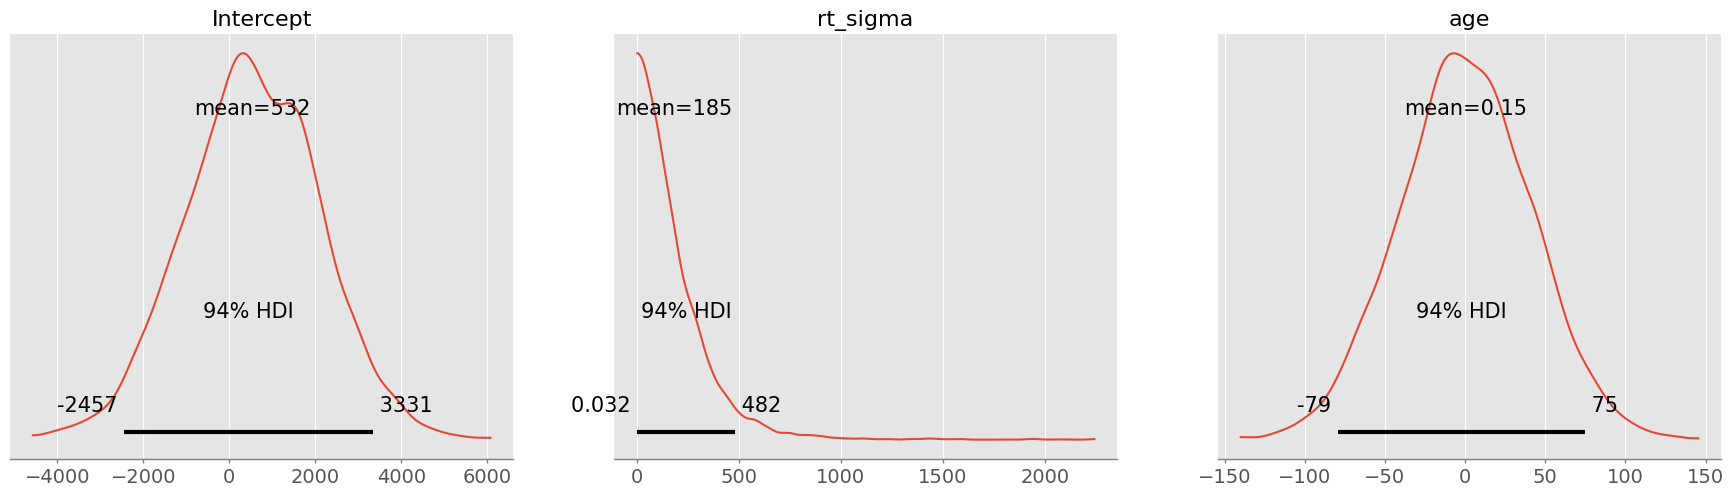

In [36]:
model.plot_priors()

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'rt_sigma'}>,
        <AxesSubplot:title={'center':'rt_sigma'}>]], dtype=object)

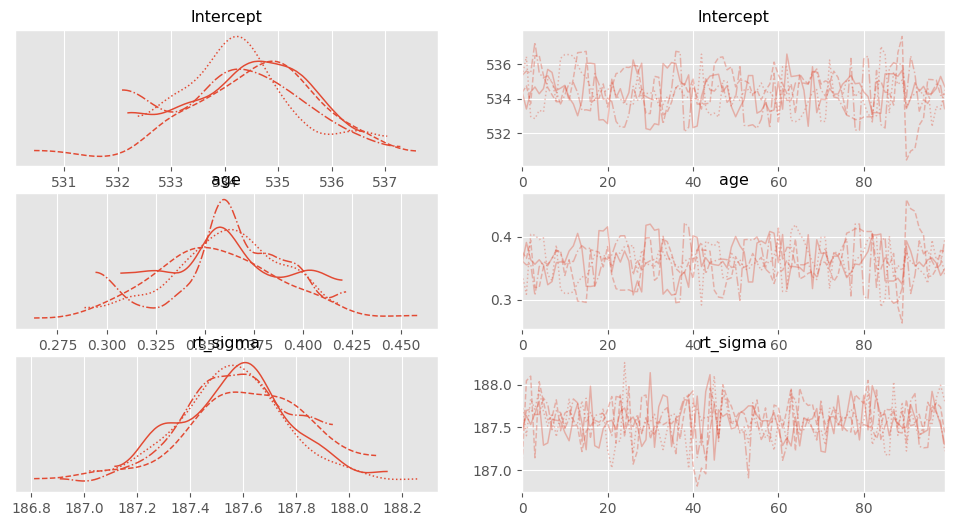

In [37]:
pm.plot_trace(idata)

In [38]:
import arviz as az
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,534.401,1.162,532.270,536.499,0.078,0.056,227.0,216.0,1.01
age,0.361,0.031,0.301,0.414,0.002,0.001,240.0,155.0,1.02
rt_sigma,187.579,0.223,187.170,188.002,0.011,0.008,434.0,254.0,1.00


array([<AxesSubplot:title={'center':'Intercept'}>,
       <AxesSubplot:title={'center':'age'}>,
       <AxesSubplot:title={'center':'rt_sigma'}>], dtype=object)

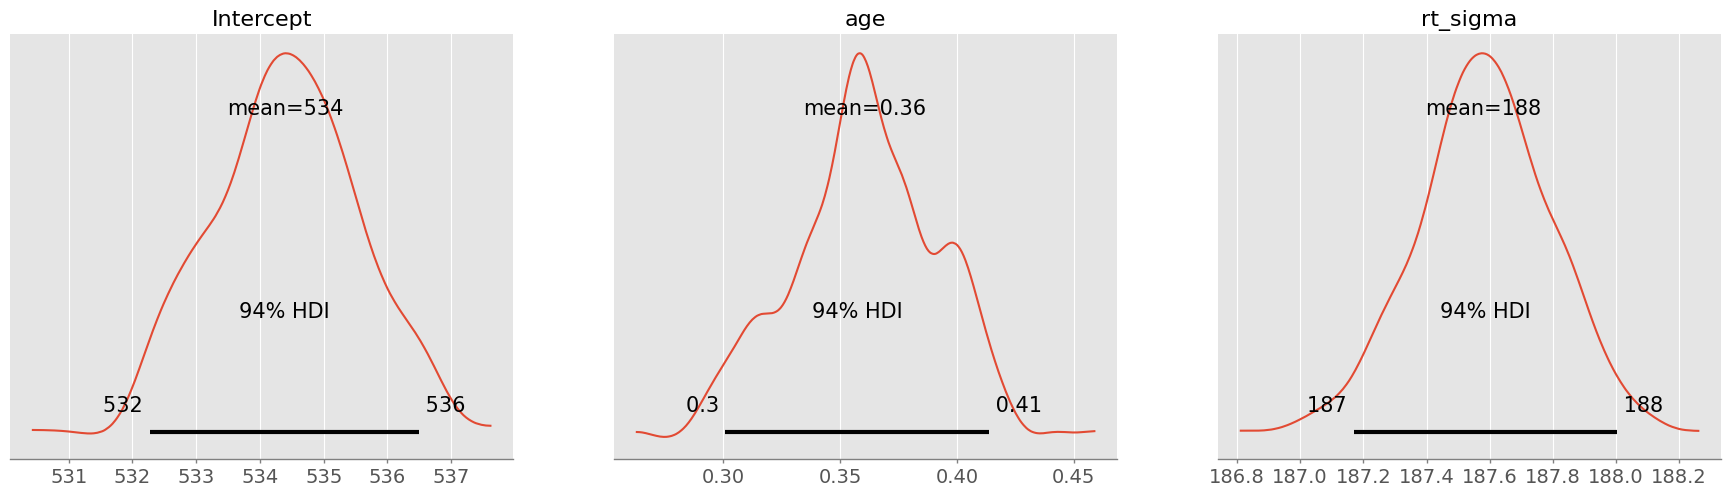

In [39]:
pm.plot_posterior(idata)

In [40]:
# with pm.Model() as normal_model:
#     family = pm.glm.families.Normal()
#     pm.GLM.from_formula("rt ~ is_pull + is_happy + session_number", 
#                         data=happy_data, 
#                         family=family)
#     normal_trace = pm.sample(draws=2000, chains=2, tune=500, njobs=-1)

In [41]:
import numpy as np 
import scipy

<AxesSubplot:xlabel='rt', ylabel='session_number'>

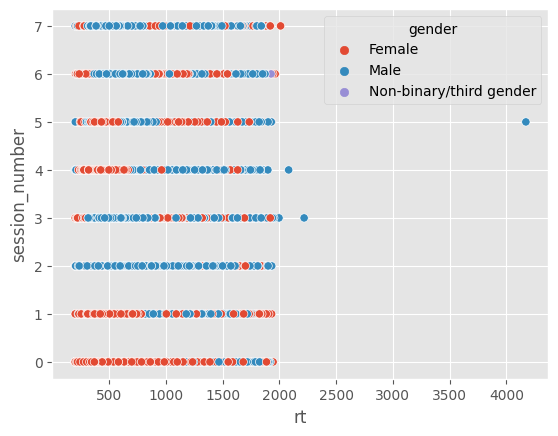

In [42]:
sns.scatterplot(x='rt',
                y='session_number',
               data=happy_data,
               hue="gender")

In [43]:
happy_data['age_group'] = happy_data.age.apply(lambda x: 'young' if x<=33 else 'old')

/tmp/ipykernel_19378/3573302453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  happy_data['age_group'] = happy_data.age.apply(lambda x: 'young' if x<=33 else 'old')


In [44]:
pd.set_option('display.max_columns', None)

In [45]:
def convert_time(x):
    if x>6 and x<12: return "Morning"
    elif x>12 and x<16: return "Afternoon"
    elif x>16 and x<21: return "Evening"
    elif x<6 or x>21: return "Night"

In [46]:
happy_data['time_of_day_group'] = happy_data.time_of_day.apply(convert_time)

/tmp/ipykernel_19378/416130371.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  happy_data['time_of_day_group'] = happy_data.time_of_day.apply(convert_time)


In [47]:
happy_data.time_of_day_group.value_counts()

Evening      143875
Night        104093
Afternoon     58615
Morning       13354
Name: time_of_day_group, dtype: int64

In [48]:
happy_data.groupby(['response', 'gender'])['force'].mean()

response  gender                 
pull      Female                     11.705575
          Male                       12.606467
          Non-binary/third gender    12.398238
push      Female                     11.068950
          Male                       11.855453
          Non-binary/third gender    11.675054
Name: force, dtype: float64

In [49]:
happy_data.groupby('response')['force'].mean()

response
pull    12.174808
push    11.478175
Name: force, dtype: float64

In [50]:
happy_data.groupby(['response', 'age_group'])['force'].mean()

response  age_group
pull      old          12.360318
          young        11.980647
push      old          11.337016
          young        11.625870
Name: force, dtype: float64

In [51]:
def device_cat(x):
    if "Pixel" in x: return "Pixel"
    elif "SM" in x: return "Samsung"
    elif "LG" in x: return "LG"
    elif "Moto" in x: return "Moto"
    elif "Redmi" in x: return "Redmi"
    elif "Nexus" in x: return "Nexus"

In [52]:
happy_data['device'] = happy_data.device.apply(device_cat)
happy_data = happy_data.dropna()

/tmp/ipykernel_19378/1405126253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  happy_data['device'] = happy_data.device.apply(device_cat)


In [53]:
happy_data.groupby(['response', 'device'])['force'].mean()

response  device 
pull      LG         11.962777
          Moto       10.195187
          Nexus      13.826791
          Pixel      11.542997
          Redmi      10.704964
          Samsung    12.151067
push      LG         10.969921
          Moto       10.313176
          Nexus      13.362740
          Pixel      11.527595
          Redmi      10.684509
          Samsung    11.255719
Name: force, dtype: float64

In [54]:
happy_data.groupby(['response', 'session_number'])['force'].mean()

response  session_number
pull      0                 12.653618
          1                 11.690299
          2                 11.585834
          3                 11.650950
          4                 11.526750
          5                 12.032276
          6                 12.446043
push      0                 11.785478
          1                 10.927293
          2                 10.931728
          3                 10.932287
          4                 10.797339
          5                 11.441056
          6                 11.776617
Name: force, dtype: float64

Text(0.5, 1.0, 'Happy')

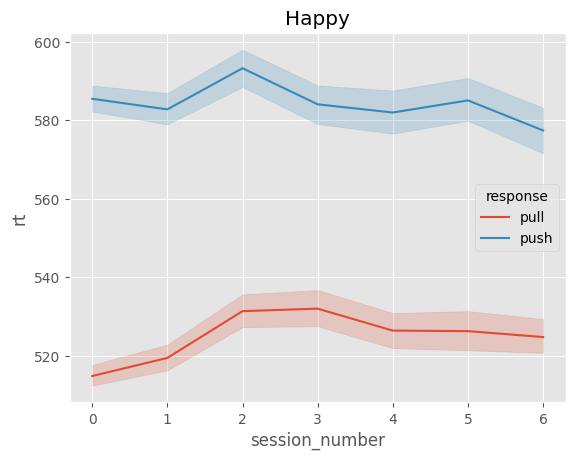

In [55]:
# fig, ax = plt.subplots(1,2, figsize=(10, 5))

sns.lineplot(x="session_number", y="rt", hue="response", data=happy_data.query("is_happy==True"))
plt.title('Happy')
# sns.lineplot(x="session_number", y="rt", hue="response", data=happy_data.query("is_happy==False"), ax=ax[1])

In [56]:
!pip install pingouin --quiet
import pingouin as pg

In [57]:
happy_data

,participant,PID_fixed,experiment,session,stimulus_set,stimulus,is_pull,rt,rt_inv,force,response,dq_mean,post_error,trial,task_trial,block_trial,time_of_day,age,gender,session_number,is_female,condition,device,DQ_02,DQ_03,DQ_04,DQ_05,DQ_06,DQ_07,DQ_08,C5_02,C5_03,C5_04,C5_05,C5_06,C5_07,is_happy,is_dirty,session_number_c,is_happy_c,is_pull_c,age_group,time_of_day_group
106,kekytm5d,5e1f9c6e105841000c7740d9,session6,push_sad_aat_1_session,sad_1,t3_a_pms8_sad,False,403.0,2.481390,25.707233,push,4.000000,False,9,1,1,6.033333,34.0,Female,5,True,push_harmful_1,Pixel,5.0,4.0,4.0,4.0,4.0,3.0,4.0,5.0,2.0,5.0,5.0,2.0,2.0,False,False,2.233179,-0.272259,-0.499916,old,Morning
107,kekytm5d,5e1f9c6e105841000c7740d9,session6,push_sad_aat_1_session,happy_1,t14_w_cih2_happy,True,492.0,2.032520,23.503792,pull,4.000000,False,10,2,2,6.033333,34.0,Female,5,True,push_harmful_1,Pixel,5.0,4.0,4.0,4.0,4.0,3.0,4.0,5.0,2.0,5.0,5.0,2.0,2.0,True,False,2.233179,0.727741,0.500084,old,Morning
108,kekytm5d,5e1f9c6e105841000c7740d9,session6,push_sad_aat_1_session,happy_1,t3_a_cih2_happy,True,730.0,1.369863,23.840299,pull,4.000000,False,11,3,3,6.033333,34.0,Female,5,True,push_harmful_1,Pixel,5.0,4.0,4.0,4.0,4.0,3.0,4.0,5.0,2.0,5.0,5.0,2.0,2.0,True,False,2.233179,0.727741,0.500084,old,Morning
109,kekytm5d,5e1f9c6e105841000c7740d9,session6,push_sad_aat_1_session,sad_1,t3_w_pms8_sad,False,645.0,1.550388,20.579197,push,4.000000,False,12,4,4,6.033333,34.0,Female,5,True,push_harmful_1,Pixel,5.0,4.0,4.0,4.0,4.0,3.0,4.0,5.0,2.0,5.0,5.0,2.0,2.0,False,False,2.233179,-0.272259,-0.499916,old,Morning
111,kekytm5d,5e1f9c6e105841000c7740d9,session6,push_sad_aat_1_session,happy_1,t9_w_adh2_happy,True,749.0,1.335113,17.961514,pull,4.000000,True,14,6,6,6.033333,34.0,Female,5,True,push_harmful_1,Pixel,5.0,4.0,4.0,4.0,4.0,3.0,4.0,5.0,2.0,5.0,5.0,2.0,2.0,True,False,2.233179,0.727741,0.500084,old,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924294,kcap0xzb,5d42486206811e001ada5b4b,session4,push_sad_aat_1_session,happy_2,t20_af_adh2_happy,False,611.0,1.636661,3.893258,push,4.428571,False,92,36,16,16.283333,44.0,Male,3,False,push_harmful_1,Samsung,5.0,5.0,4.0,5.0,5.0,3.0,4.0,1.0,5.0,1.0,2.0,5.0,5.0,True,False,0.233179,0.727741,-0.499916,old,Evening
924295,kcap0xzb,5d42486206811e001ada5b4b,session4,push_sad_aat_1_session,sad_2,t14_w_pms6_sad,True,740.0,1.351351,1.995418,pull,4.428571,False,93,37,17,16.283333,44.0,Male,3,False,push_harmful_1,Samsung,5.0,5.0,4.0,5.0,5.0,3.0,4.0,1.0,5.0,1.0,2.0,5.0,5.0,False,False,0.233179,-0.272259,0.500084,old,Evening
924296,kcap0xzb,5d42486206811e001ada5b4b,session4,push_sad_aat_1_session,sad_2,t20_a_pms6_sad,True,1218.0,0.821018,5.066221,pull,4.428571,False,94,38,18,16.283333,44.0,Male,3,False,push_harmful_1,Samsung,5.0,5.0,4.0,5.0,5.0,3.0,4.0,1.0,5.0,1.0,2.0,5.0,5.0,False,False,0.233179,-0.272259,0.500084,old,Evening
924297,kcap0xzb,5d42486206811e001ada5b4b,session4,push_sad_aat_1_session,sad_2,t15_wf_pms8_sad,True,605.0,1.652893,10.937866,pull,4.428571,False,95,39,19,16.283333,44.0,Male,3,False,push_harmful_1,Samsung,5.0,5.0,4.0,5.0,5.0,3.0,4.0,1.0,5.0,1.0,2.0,5.0,5.0,False,False,0.233179,-0.272259,0.500084,old,Evening


In [58]:
pg.intraclass_corr(data=happy_data, targets='is_happy', raters='participant', ratings='rt')

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.004682,14.541664,1,5756,1.385275e-04,"[0.0, 0.84]"
1,ICC2,Single random raters,0.004997,177.732020,1,2878,2.179732e-39,"[0.0, 0.84]"
2,ICC3,Single fixed raters,0.057836,177.732020,1,2878,2.179732e-39,"[0.01, 0.98]"
3,ICC1k,Average raters absolute,0.931232,14.541664,1,5756,1.385275e-04,"[0.65, 1.0]"
4,ICC2k,Average random raters,0.935316,177.732020,1,2878,2.179732e-39,"[0.74, 1.0]"
5,ICC3k,Average fixed raters,0.994374,177.732020,1,2878,2.179732e-39,"[0.97, 1.0]"


In [59]:
icc1ks = []

for i in range(7):
    res = pg.intraclass_corr(data=happy_data.query(f"session_number=={i}"), targets='is_happy', raters='participant', ratings='rt')
    print(f"Session {i}")
    print(f"ICC1k: {res[res.Type=='ICC1k']['ICC'].values[0]}")
    icc1ks.append(res[res.Type=='ICC1k']['ICC'].values[0])

Session 0
ICC1k: 0.6175051742675478
Session 1
ICC1k: 0.6808341089163553
Session 2
ICC1k: 0.5612523487441338
Session 3
ICC1k: 0.3952066002115356
Session 4
ICC1k: 0.3350706105496666
Session 5
ICC1k: 0.29007023590355896
Session 6
ICC1k: 0.5481965905670968


<AxesSubplot:>

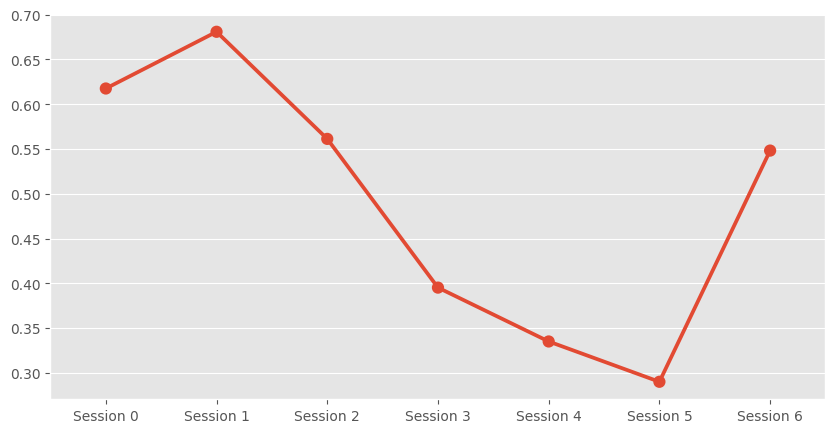

In [60]:
plt.figure(figsize=(10,5))
sns.pointplot(y=icc1ks, x=[f"Session {i}" for i in range(7)])

In [82]:
pg.normality(np.log(data.rt))

/home2/anmol.goel/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home2/anmol.goel/miniconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,W,pval,normal
rt,NaN,1.0,True


<AxesSubplot:xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

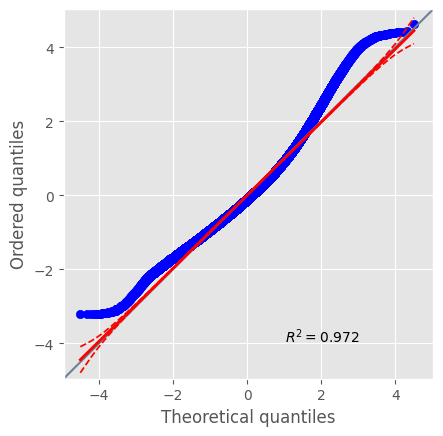

In [84]:
pg.qqplot(np.log(happy_data.rt), dist='norm', confidence=0.9)

<AxesSubplot:xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

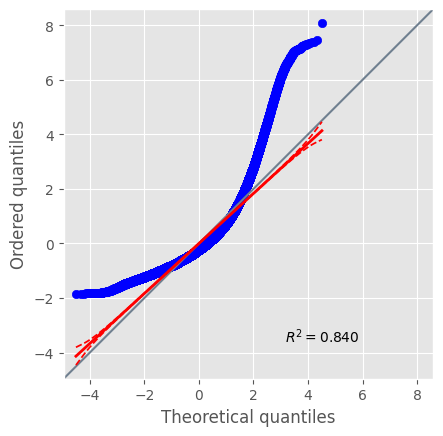

In [85]:
pg.qqplot(happy_data.rt, dist='norm', confidence=0.9)

In [112]:
expected, observed, stats = pg.chi2_independence(happy_data, x='gender',
                                                 y='age_group')

In [113]:
expected

age_group,old,young
gender,,
Female,51794.325734,52279.674266
Male,51227.481595,51707.518405
Non-binary/third gender,2093.192671,2112.807329


In [114]:
observed

age_group,old,young
gender,,
Female,57035,47039
Male,46700,56235
Non-binary/third gender,1380,2826


In [115]:
stats.round(2)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.00,2335.91,2.0,0.0,0.11,1.0
1,cressie-read,0.67,2338.80,2.0,0.0,0.11,1.0
2,log-likelihood,0.00,2348.90,2.0,0.0,0.11,1.0
3,freeman-tukey,-0.50,2360.41,2.0,0.0,0.11,1.0
4,mod-log-likelihood,-1.00,2375.51,2.0,0.0,0.11,1.0
5,neyman,-2.00,2417.42,2.0,0.0,0.11,1.0


In [119]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,534.401,1.162,532.270,536.499,0.078,0.056,227.0,216.0,1.01
age,0.361,0.031,0.301,0.414,0.002,0.001,240.0,155.0,1.02
rt_sigma,187.579,0.223,187.170,188.002,0.011,0.008,434.0,254.0,1.00
